In [26]:
import matplotlib.pyplot as plt
import json

def plot_debug_log(log_path):
    times = []
    rates1 = []
    rates2 = []
    rates3 = []
    total_rates = []

    with open(log_path, 'r') as f:
        for line in f:
            try:
                obj = json.loads(line.strip())
                t = obj.get('timepoint', None)
                r1 = obj.get('task_1_rate', None)
                r2 = obj.get('task_2_rate', None)
                r3 = obj.get('task_3_rate', None)
                total = obj.get('total_rate', None)
                if t is not None:
                    times.append(t * 10)  # 单位为10ms
                    rates1.append(r1 if r1 is not None else None)
                    rates2.append(r2 if r2 is not None else None)
                    rates3.append(r3 if r3 is not None else None)
                    total_rates.append(total if total is not None else None)
            except Exception as e:
                continue

    plt.figure(figsize=(16, 6))
    # 绘制三条流的速率
    plt.plot(times, rates1, label='task_1_rate')
    plt.plot(times, rates2, label='task_2_rate')
    plt.plot(times, rates3, label='task_3_rate')
    # 绘制总速率，虚线
    plt.plot(times, total_rates, label='total_rate', color='black', linewidth=2, linestyle='--')

    plt.xlabel('time (ms)')
    plt.ylabel('rate (Gbps)')
    plt.title('Rate Info from debug.log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def cacu_fair_factor(log_path):
    times = []
    rates1 = []
    rates2 = []
    rates3 = []
    total_rates = []
    fair_arr = []
    with open(log_path, 'r') as f:
        for line in f:
            try:
                obj = json.loads(line.strip())
                t = obj.get('timepoint', None)
                r1 = obj.get('task_1_rate', None)
                r2 = obj.get('task_2_rate', None)
                r3 = obj.get('task_3_rate', None)
                total = obj.get('total_rate', None)
                f = []
                if t is not None:
                    f.append(r1 if r1 is not None else 0)
                    f.append(r2 if r2 is not None else 0)
                    f.append(r3 if r3 is not None else 0)
                    sum_sq = 0
                    sq_sum = 0
                    count = 0
                    for elem in f:
                        if elem > 0:
                            sum_sq += elem
                            sq_sum += elem * elem
                            count += 1
                    f = sum_sq * sum_sq / sq_sum / count
                    fair_arr.append(f)
            except Exception as e:
                continue
    print("公平指数：",sum(fair_arr) / len(fair_arr))

def cacu_oscillation_factor(log_path, w:int = 10):
    def find_median(arr):
        if not arr:
            return 0
        sorted_arr = sorted(arr)
        n = len(sorted_arr)
        mid = n // 2
        if n % 2 == 0:
            return (sorted_arr[mid - 1] + sorted_arr[mid]) / 2
        else:
            return sorted_arr[mid]
    diff_abs = lambda arr, val: find_median([abs(x - val) for x in arr])
    fair_arr = []
    sum_sq = 0
    sq_sum = 0
    count = 0
    times = []
    slide_windows = [[],[],[]]
    osci = [None, None, None]
    with open(log_path, 'r') as f:
        for line in f:
            try:
                obj = json.loads(line.strip())
                t = obj.get('timepoint', None)
                r1 = obj.get('task_1_rate', None)
                r2 = obj.get('task_2_rate', None)
                r3 = obj.get('task_3_rate', None)
                total = obj.get('total_rate', None)
                if t is not None:
                    for i, elem in enumerate([r1, r2, r3]):
                        if elem is not None:
                            if len(slide_windows[i]) >= w:
                                slide_windows[i].pop(0)
                            slide_windows[i].append(elem)
                            ref = find_median(slide_windows[i])
                            mad = diff_abs(slide_windows[i], ref)
                            if osci[i] is None:
                                osci[i] = 1 - mad /max(1e-6, ref)
                            else:
                                osci[i] = 0.5 * osci[i] + 0.5 * (1 - mad / max(1e-6, ref))
                            # print(f"task_{i+1}_oscillation: {osci[i]:.4f}")
            except Exception as e:
                continue
    print("振荡指数：", osci)
# 用法

公平指数： 0.8184465038877754
振荡指数： [0.9723666695558595, 0.9836982123399244, 0.9436026468953369]


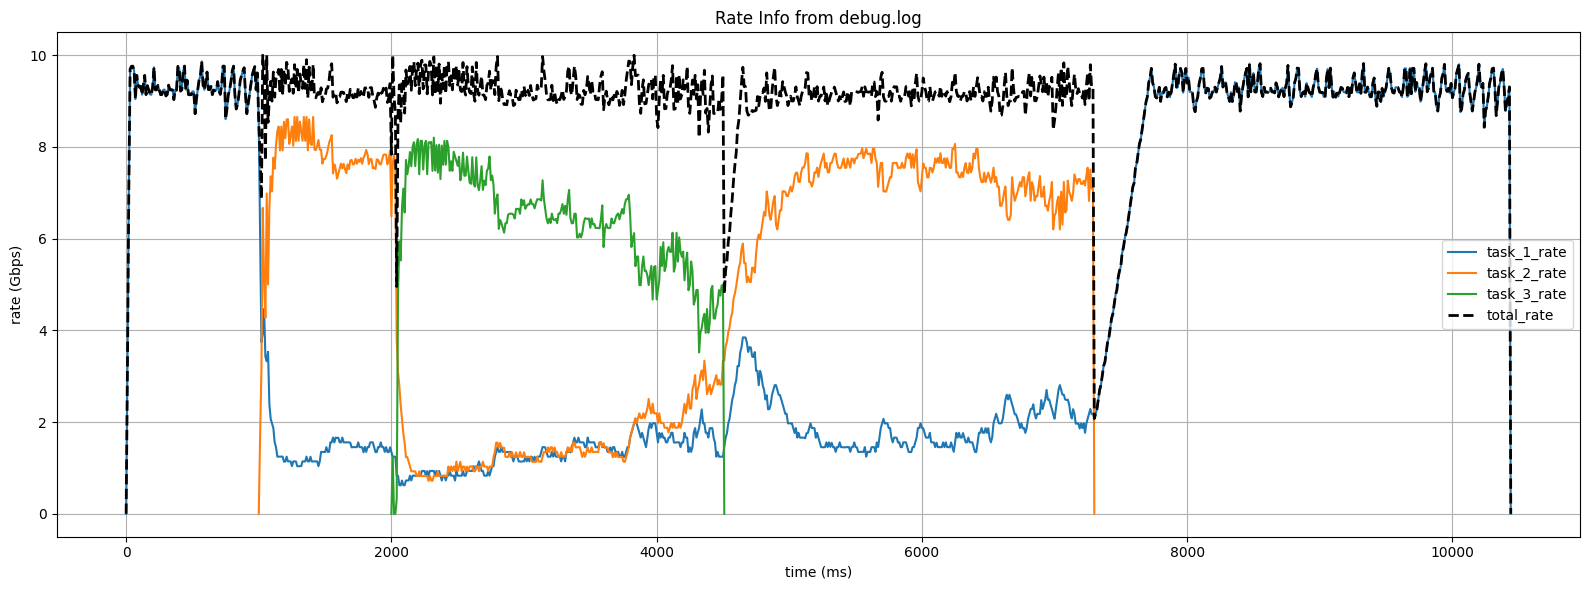

In [31]:
#DOWN
cacu_fair_factor('debug.log')
cacu_oscillation_factor('debug.log', 10)
plot_debug_log('debug.log')

公平指数： 0.9995240328139017
振荡指数： [0.9998244947446464, 0.9907165175213082, 0.9985550184503756]


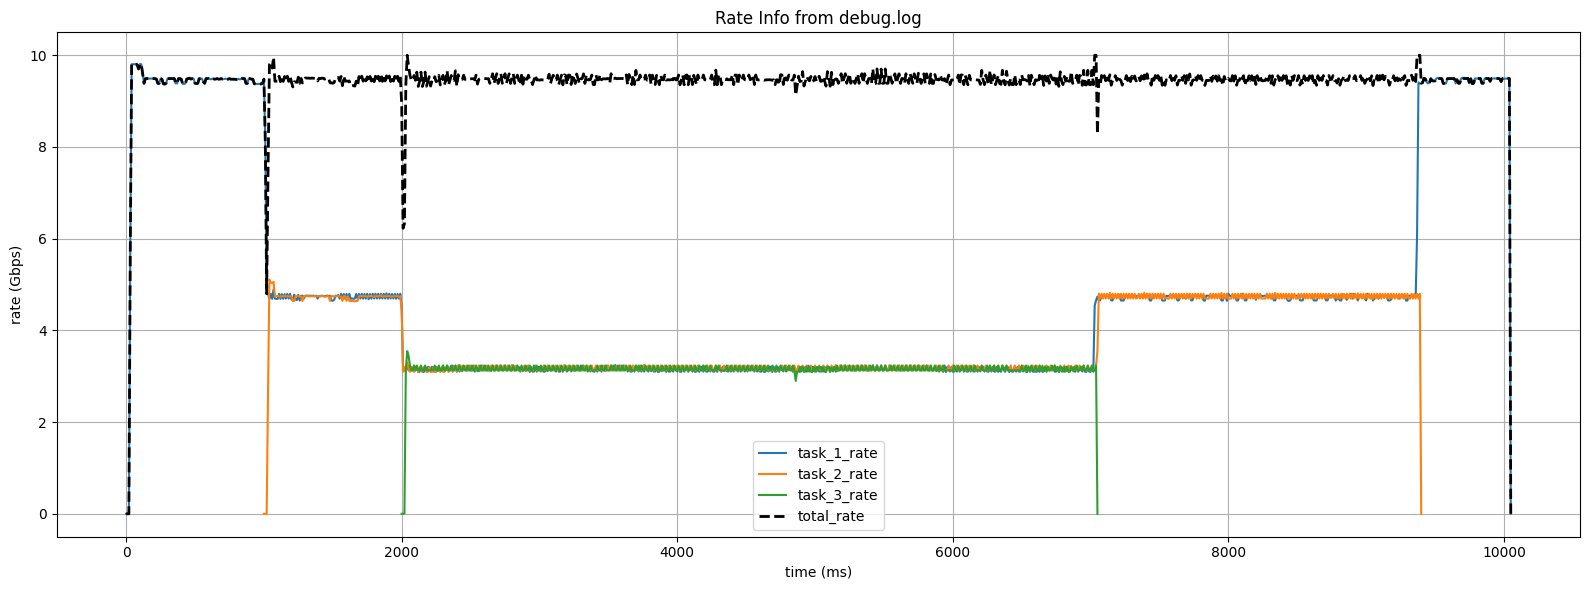

In [30]:
#UP
cacu_fair_factor('debug.log')
cacu_oscillation_factor('debug.log', 10)
plot_debug_log('debug.log')